In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import copy

from IPython.display import Video

In [2]:
CUDA = torch.cuda.is_available()
RANDOM_SEED = 9
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 9

print(f"CUDA: {CUDA}")

CUDA: False


In [3]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
data = pd.read_csv("training_set/scores_v2.csv").set_index("video_id")
Video(data.iloc[22]["video_url"])

In [5]:
from collections import defaultdict
import os
import tqdm 
from collections import defaultdict
from IPython.display import Video
from Katna.video import Video as KatnaVideo
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request 
from fer import FER
import cv2
import numpy as np

def extract_emotions():
    filenames = os.listdir("training_set/Features/AlexNetFC7")
    filenames.sort(key=lambda filename: int(filename[:5]))

    vd = KatnaVideo()

    failed = [] 
    fer = defaultdict(dict) 
    detector = FER()

    for filename in tqdm.tqdm(filenames): 
        video_number = filename[:5]
        frame_number = filename[6:9]
        try: 
            img = cv2.imread(f"./training_set/Frames/{video_number}-{frame_number}.png")
            emotions_likelihood = detector.detect_emotions(img)
            if emotions_likelihood: 
                fer[video_number][frame_number] = (emotions_likelihood)
            else: 
                raise Exception 
        except: 
            failed.append(filename)
    return fer 
fer = extract_emotions()



Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
20-10-2020:22:38:53,367 WARNING  [deprecation.py:317] From /Users/kimjef/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
100%|██████████| 1770/1770 [00:43<00:00, 40.53it/s]


In [68]:
def load_emotions(fer): 
    filenames = os.listdir("training_set/Features/AlexNetFC7")
    filenames.sort(key=lambda filename: int(filename[:5]))

    d = defaultdict(lambda: np.array([])) 
    emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    for filename in filenames: 
        video_number = filename[:5]
        frame_number = filename[6:9]
        analysis = frame_number in fer[video_number] and fer[video_number][frame_number]
        if analysis: 
            default = np.array([0 for i in range(7)])
            num_faces = len(fer[video_number][frame_number]) 
            zero_face   = np.array([fer[video_number][frame_number][0]["emotions"][emotion] for emotion in emotions]) \
                                if num_faces > 1 else default
            first_face  = np.array([fer[video_number][frame_number][1]["emotions"][emotion] for emotion in emotions]) \
                                if num_faces > 2 else default
            second_face = np.array([fer[video_number][frame_number][2]["emotions"][emotion] for emotion in emotions]) \
                                if num_faces > 3 else default
            third_face  = np.array([fer[video_number][frame_number][3]["emotions"][emotion] for emotion in emotions]) \
                                if num_faces > 4 else default
            fourth_face = np.array([fer[video_number][frame_number][4]["emotions"][emotion] for emotion in emotions]) \
                                if num_faces > 5 else default
            d[int(video_number)] = np.hstack([d[int(video_number)], 
                                            zero_face, 
                                            first_face,
                                            second_face, 
                                            third_face, 
                                            fourth_face])
        else: 
            d[int(video_number)] = np.hstack([d[int(video_number)], 
                                          np.array([0 for emotion in range(5 * len(emotions))])])
                                            #   np.array([1/len(emotions) for emotion in emotions])])
    return pd.Series(d)

data["emotion"] = load_emotions(fer)


In [69]:
def load_C3D_features(video_ids, path ="training_set/Features/C3D/"):
    features = []
    for video_id in video_ids:
        filename = f"{path}{f'{video_id}'.zfill(5)}.mp4.csv"
        features.append(np.loadtxt(filename, delimiter=","))
    return features
data["c3d"] = load_C3D_features(data.index)

In [70]:
st_annotations = pd.read_csv("training_set/short_term_annotations.csv")
st_annotations["t"] = st_annotations["video_position_second"] - st_annotations["video_position_first"]
st_annotations.head()

,video_id,video_url,user_id,rt,key_press,video_position_first,video_position_second,correct,t
0,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,129,1958,32,59,147,1,88
1,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,212,1077,32,32,101,1,69
2,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,335,1067,32,70,120,1,50
3,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,439,2265,32,55,106,1,51
4,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,505,1520,32,67,135,1,68


In [71]:
print("Average t:", np.mean(st_annotations["t"]))

Average t: 74.81127450980392


In [72]:
# We use approximately the average_t to calculate T as the memorability in question
big_t = 75

In [73]:
def calculate_alpha(annotations, m_T, T = 75):
    numerator = 0
    denominator = 0
    for video_id, video in annotations.groupby("video_id"):
        t = video["t"].to_numpy()
        x = video["correct"].to_numpy()
        n = len(video)
        m = m_T[video_id]
        for j in range(n):
            numerator += (np.log(t[j] / T) * (x[j] - m)) / n
            denominator += (np.log(t[j] / T) ** 2) / n

    return numerator / denominator

In [74]:
def calculate_memorability(annotations, alpha, T = 75):
    m_T = {}
    for video_id, video in annotations.groupby("video_id"):
        t = video["t"].to_numpy()
        x = video["correct"].to_numpy()
        n = len(video)
        m = 0
        for j in range(n):
            m += x[j] - (alpha * np.log(t[j] / T))
        m_T[video_id] = m / n
    return m_T

In [75]:
num_iterations = 10

m_T = {video_id: 1 for video_id in st_annotations["video_id"]}
for iteration in range(num_iterations):
    alpha = calculate_alpha(st_annotations, m_T, T = big_t)
    m_T = calculate_memorability(st_annotations, alpha, T = big_t)
print(alpha)

-0.00027284180298008494


In [76]:
data[f"m_{big_t}"] = pd.Series(m_T)

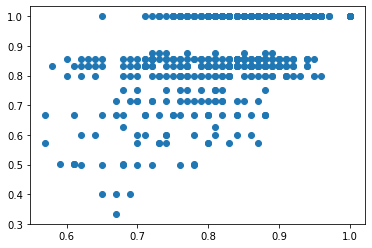

In [77]:
plt.scatter(data["part_1_scores"], data[f"m_{big_t}"])
plt.show()

In [78]:
class FlatDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [110]:
class DropOutNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = 100):
        super(DropOut, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 1024)
        self.drop1 = torch.nn.Dropout(0.25)
        self.linear2 = torch.nn.Linear(1024, 512)
        self.drop1 = torch.nn.Dropout(0.25)
        self.linear3 = torch.nn.Linear(512, 256)
        self.drop1 = torch.nn.Dropout(0.25)
        self.linear4 = torch.nn.Linear(256, 128)
        self.drop1 = torch.nn.Dropout(0.25)
        self.linear5 = torch.nn.Linear(128, 64)
        self.drop1 = torch.nn.Dropout(0.25)
        self.linear6 = torch.nn.Linear(64, 32)
        self.drop1 = torch.nn.Dropout(0.25)
        self.linear7 = torch.nn.Linear(32, output_dim)

        self.act = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.act(self.linear1(x))
        x = self.drop1(x)
        x = self.act(self.linear2(x))
        x = self.drop2(x)
        x = self.act(self.linear3(x))
        x = self.drop3(x)
        x = self.act(self.linear4(x))
        x = self.drop4(x)
        x = self.act(self.linear5(x))
        x = self.drop5(x)
        x = self.act(self.linear6(x))
        x = self.drop6(x)
        x = self.act(self.linear7(x))
        return x


In [79]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = 100):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.tanh = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x
        

In [80]:
def split_training(data: pd.DataFrame, shuffle=True, split=0.8):
    ids = np.random.permutation(list(data.index)) if shuffle else list(data.index)
    split_index = int(len(ids) * split)
    return data.loc[ids[:split_index]], data.loc[ids[split_index:]]

In [86]:
def build_matrixes(data: pd.DataFrame, targets, features, dtype="double"):
    feature_matrix = [np.concatenate(list(row_features), axis=None) 
                      for row_features in zip(*[list(data[feature]) for feature in features])]
    target_matrix = list(data[targets])
    return np.array(feature_matrix, dtype=dtype), np.array(target_matrix, dtype=dtype).reshape((len(target_matrix),1))

In [88]:
target = "m_75"
features = ["emotion"]

def get_model(data, target, features, modelClass): 
    train, valid = split_training(data)
    features_train, targets_train = build_matrixes(train, targets = target, features = features)
    
    features_valid, targets_valid = build_matrixes(valid, targets = target, features = features)
    data_train = FlatDataset(features_train, targets_train)
    data_valid = FlatDataset(features_valid, targets_valid)
    input_dim = len(features_train[0])
    output_dim = 1 if len(targets_train.shape) == 1 else len(targets_train[0])
    model = modelClass(input_dim, output_dim)

    num_epochs = NUM_EPOCHS
    batch_size = BATCH_SIZE
    learning_rate = LEARNING_RATE
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma = 0.5)

    dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = torch.utils.data.DataLoader(data_valid, batch_size=1)
    device = torch.device("cuda") if CUDA else torch.device("cpu")
    model = model.double().to(device)


    return model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device 

_ = get_model(data, target, features, TwoLayerNet)
model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device = _ 

In [93]:
def train_model(model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device):
    
    for is_training in [True, False]: # Epoch is a training followed by validation 
        
        model.train() if is_training else model.eval()

        running_loss = 0
        for features, targets in (dataloader_train if is_training else dataloader_valid):
            features = features.to(device) 
            targets = targets.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(is_training):
                outputs = model(features)
                loss = loss_fn(outputs, targets)
                if is_training:
                    loss.backward()
                    optimizer.step()               
            running_loss += loss.item()
        
        if is_training:
            scheduler.step()
        
        if is_training:
            train_loss = running_loss / len(dataloader_train.dataset)
        else:
            valid_loss = running_loss / len(dataloader_valid.dataset)
    
    return train_loss, valid_loss



In [95]:
def get_best_model(model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device): 
    best_valid_loss = 9999999
    best_model_state_dict = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        # print(f"--------------- Epoch {epoch} ----------------")
        train_loss, val_loss = train_model(model = model,
                                    dataloader_train = dataloader_train,
                                    dataloader_valid = dataloader_valid,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer,
                                    scheduler = scheduler,
                                    device = device)
        
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            best_model_state_dict = copy.deepcopy(model.state_dict())
            # print("New Best Validiation Loss!!!", val_loss)
        
        # print("Training Loss:", train_loss)
        # print("Validation Loss:", val_loss)
    # print("\n\nFINISHED TRAINING")
    print(f"Best validation lost: {best_valid_loss}")
    best_model = model
    best_model = best_model.eval()
    best_model.load_state_dict(best_model_state_dict)
    return best_model
best_model = get_best_model(model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device)

In [106]:
def save_predictions(dataloader_valid, best_model): 
    predictions = []
    actuals = []
    for feature, actual in dataloader_valid:
        with torch.set_grad_enabled(False):
            feature = feature.to(device)
            output = best_model(feature)
            predictions.append(output.cpu().numpy()[0][0])
            actuals.append(actual.cpu().numpy()[0][0])

    from tempfile import TemporaryFile 
    if not os.path.exists(f"./predictions"):
        os.mkdir(f"./predictions")
    outfile = TemporaryFile()
    with open(F'predictions/{best_model.__class__.__name__}:{"-".join(features)}.npy', 'wb') as f:
        np.save(f, np.array(predictions))
save_predictions(dataloader_valid, best_model)

In [109]:
target = "m_75"
features = ["emotion"]
combinations = [
                (TwoLayerNet, ["emotion"]),
                (TwoLayerNet, ["emotion", "c3d"]),
                (TwoLayerNet, ["c3d"])
                (DropOutNet, ["emotion"]),
               ]
for model, features in combinations: 
    _ = get_model(data, target, features, model)
    model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device = _ 
    best_model = get_best_model(model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device)
    save_predictions(dataloader_valid, best_model)